# Generating symmetry functions

_Run this notebook directly in your browser through Binder:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/runner-suite%2Frunnerase-usage-environment/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgitlab.com%252Frunner-suite%252Frunnerase-usage%26urlpath%3Dtree%252Frunnerase-usage%252Fsymfuns_generation.ipynb%26branch%3Dmain)_

The generation of suitable symmetry functions for your application is one of the most crucial but also difficult steps when generating a HDNNP. runnerase tries to make it a little easier for you by providing a tool called `generate_symmetryfunctions`. It tries to generate `SymmetryFunctionSets` based on the training dataset and cutoff radius it is provided. Let us take a look how it works in detail. 

## General Setup

As preparation, we load a sample training dataset for which we aim to generate symmetry functions.

In [1]:
import matplotlib.pyplot as plt
from ase.io import read

In [2]:
dataset = read('data/input.data', index=':', format='runnerdata')

## Radial symmetry functions

The function we need can directly be imported from the runnerase base package

In [3]:
from runnerase import generate_symmetryfunctions

First, we create radial symmetry functions. According to the Behler nomenclature, these have symmetry function type `sftype=2`. We can tell this to `generate_symmetryfunctions`:

In [4]:
radials = generate_symmetryfunctions(
    sftype=2,
    dataset=dataset,
    amount=6,
    algorithm='turn',
    cutoff=12.0
)

`generate_symmetryfunctions` searches the provided `dataset` for all elements it contains. It then creates one set of symmetryfunctions for all possible combinations of those elements. We can control how many symmetry functions _per set_ are created with the `amount` keyword. We also specify the cutoff radius _in atomic units (Bohr)_. `runnerase` implements several algorithms for the determination of the symmetry function coefficients. For radial symmetry functions these are `turn`, `half`, and `shifted`.

The function returns a `SymmetryFunctionSet` object, which recursively contains more sets itself. Let us take a look:

In [5]:
print(radials)

SymmetryFunctionSet(type=None, sets=4, symmetryfunctions=0)


In the given dataset (water dataset), there are two elements, forming four possible combination of symmetry functions: O-O, H-H, O-H and H-O. Therefore, `radials` contains four sets, one for each combination. We can dig deeper and look at the individual sets themselves:

In [6]:
for sfset in radials.sets:
    print(sfset, sfset.elements)

SymmetryFunctionSet(type=radial, sets=0, symmetryfunctions=6) ['H']
SymmetryFunctionSet(type=radial, sets=0, symmetryfunctions=6) ['H', 'O']
SymmetryFunctionSet(type=radial, sets=0, symmetryfunctions=6) ['H', 'O']
SymmetryFunctionSet(type=radial, sets=0, symmetryfunctions=6) ['O']


As you can see, the four sets do not contain any more sets but contain explicit `SymmetryFunction` objects. As we requested, they contain 6 symmetry functions for each element combination. If we look at the list representation of one of the objects

In [7]:
radials.sets[1]

[('H', 2, 'O', 7.709882115452476e-19, 0.0, 12.0), ('H', 2, 'O', 0.004521100882741771, 0.0, 12.0), ('H', 2, 'O', 0.012436078977559375, 0.0, 12.0), ('H', 2, 'O', 0.026457707902138486, 0.0, 12.0), ('H', 2, 'O', 0.05474308733334304, 0.0, 12.0), ('H', 2, 'O', 0.12712726315208278, 0.0, 12.0)]

we see that each radial symmetry function consists of six components: the central atom (H), the symmetry function type (2), the neighbor atom (O), the `eta` coefficient, the `rshift` coefficient, and the cutoff radius (12.0).

We can also visualize the symmetry functions we just created:

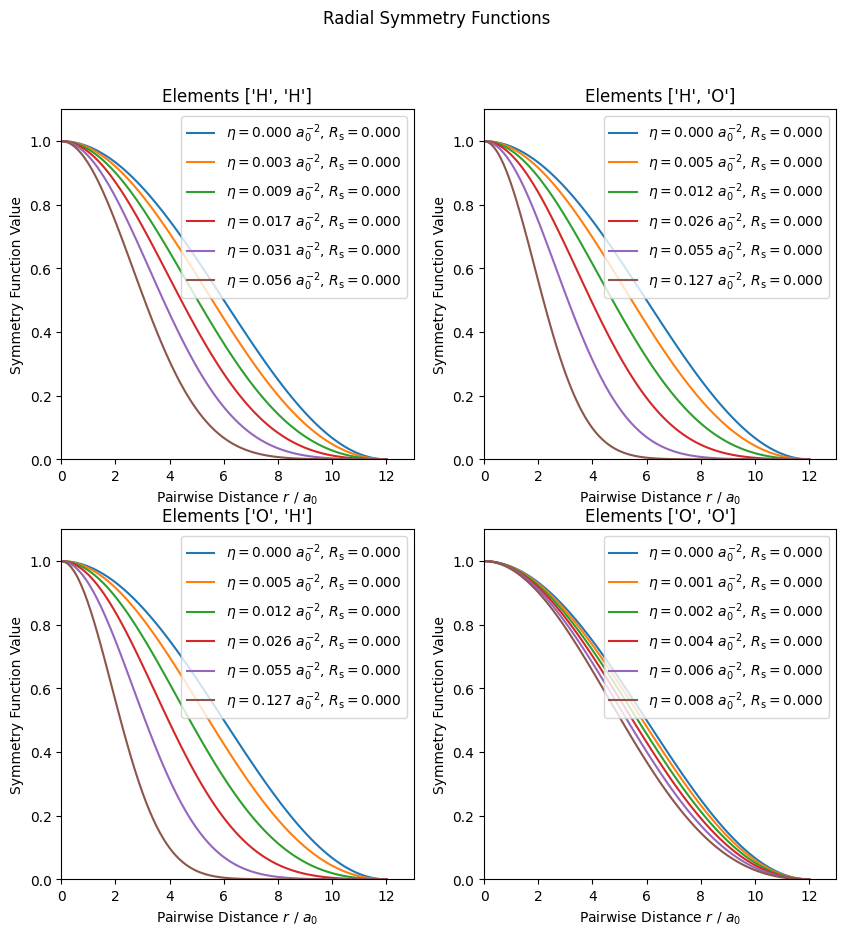

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
radials.plot.radial(axes=axes, cutoff_function=True, show_legend=True)
plt.show()

# Algorithm "shifted"

Let us try a different algorithm. The `shifted` algorithm shifts the cusp of all symmetry functions into the range between the minimum distance of that element combination in the dataset and cutoff radius: 

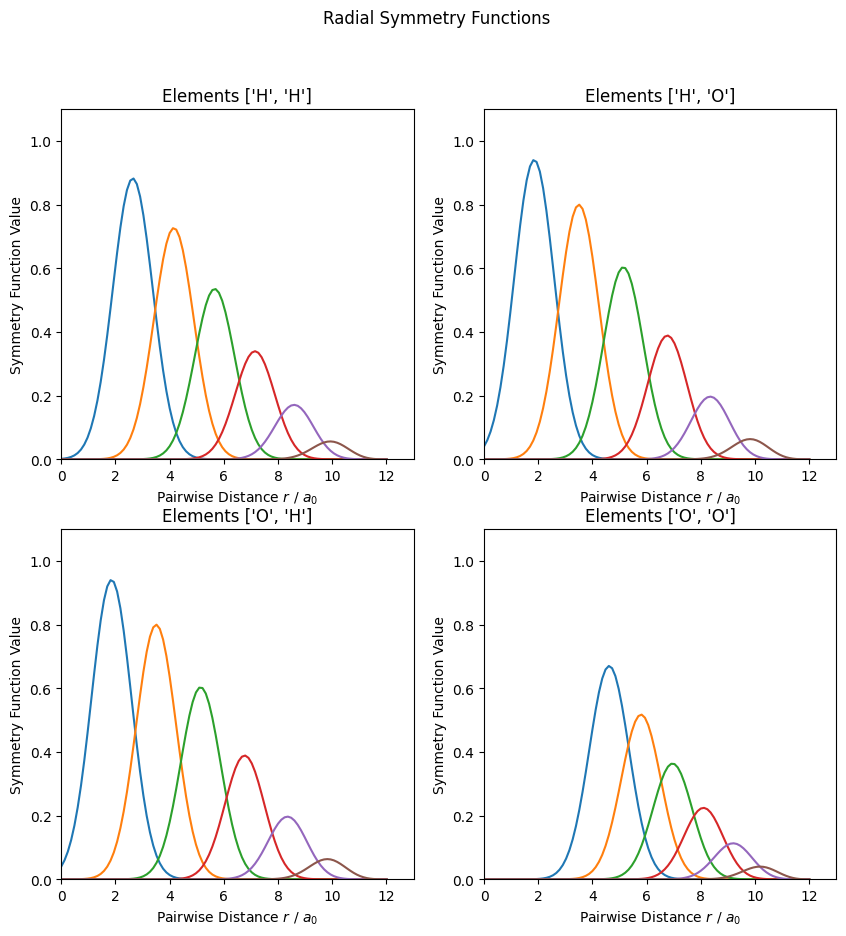

In [11]:
radials = generate_symmetryfunctions(
    sftype=2,
    dataset=dataset,
    amount=6,
    algorithm='shifted',
    cutoff=12.0
)

radials.plot.radial(cutoff_function=True, show_legend=False, figsize=(10, 10))
plt.show()

## Angular symmetry functions

We use the same function to create angular symmetry functions, too. This time, we set `sftype=3`.

In [12]:
angulars = generate_symmetryfunctions(dataset, sftype=3, amount=4,
                                      eta_angular=radials,
                                      algorithm='eta_mean', cutoff=12.0)

This uses similar keywords as for the radial symmetry functions. `cutoff`, `dataset` and `sftype` have the same meaning. The `amount` keyword still controls the number of symmetry functions in one set, but now `generate_symmetryfunctions` returns one set for each possible **triplet** of elements in the `dataset`. Therefore, increasing `amount` will more drastically increase the total number of symmetry functions in your potential.

The possible algorithms for angular symmetry functions are:

* `literature`: Create symmetry functions with the coefficients `eta=0.0`, `rshift=0` and `zeta`=[1.0, 2.0, 4.0, 16.0].
* `legacy`: Same as `literature`, but `zeta`=[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, ...] (powers of 2). This was an attempt to generalize `literature`, but has proven to work less good.
* `half` and `turn`: Determine `zeta` automatically, as for the radial symmetry functions. **Creates sharply cusped symmetry functions. DO NOT USE THIS IN PRODUCTION RUNS!**.
* `eta_mean`: Same as `literature`, but it generates two sets of angular symmetry functions with identical `zeta` and `rshift` but different `eta`: one uses `eta=0`, the other uses the mean `eta` value of the radial symmetry functions. This requires the specification of `eta_angular=radials`.


Let us look at the symetry functions we just created:

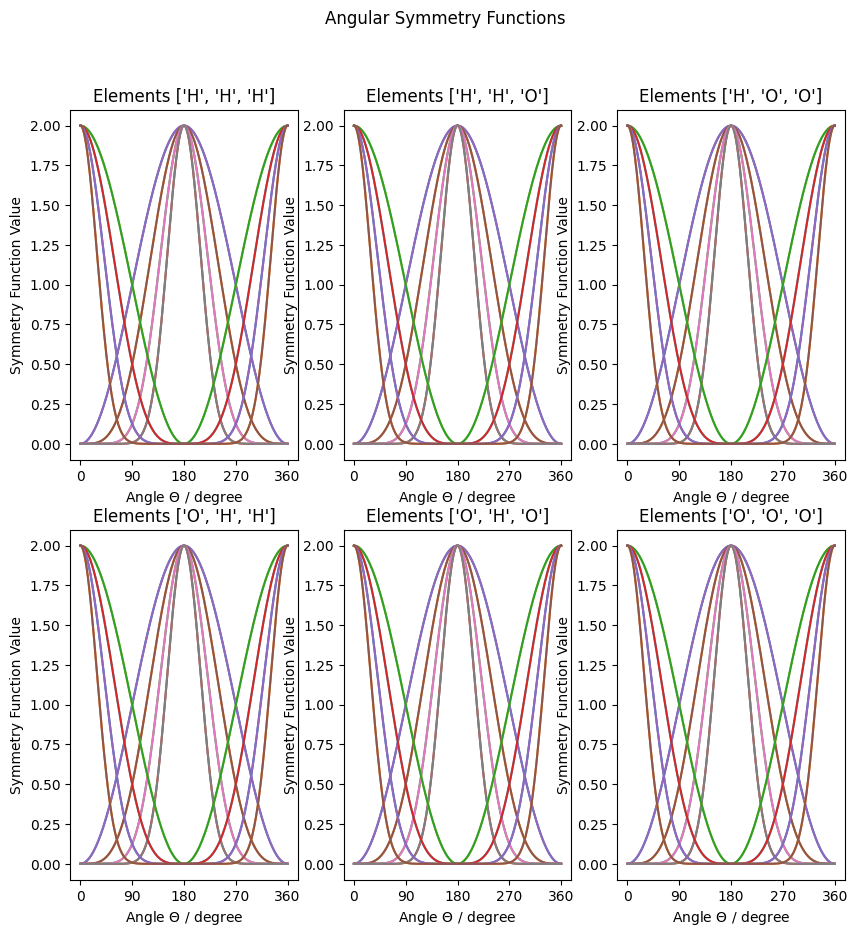

In [13]:
angulars.plot.angular(figsize=(10, 10))
plt.show()